# Building a FAISS-Based Vector Store: A Journey Through Data Processing and Visualization

In this notebook, you'll learn how to transform raw PDF documents into a searchable vector store using FAISS. We'll go on a journey where we:

1. **Read and extract text from PDF files.**
2. **Split the text into manageable chunks.**
3. **Display tokenization outputs from different tokenizers.**
4. **Generate embeddings from the text using a SentenceTransformer.**
5. **Store the embeddings in a FAISS index.**
6. **Project the embeddings into 2D space using UMAP for visualization.**
7. **Visualize the entire process on a scatter plot.**
8. **Incect your data into a prompt for a large language model**

In [21]:
import os
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np
from dotenv import load_dotenv
from groq import Groq


## 1. Reading Data from PDFs

First, we load PDF files from a directory, extract their text content, and combine it into one large text string.

In [22]:
### load the pdf from the path
glob_path = "data/*.pdf"
text = ""
for pdf_path in tqdm.tqdm(glob.glob(glob_path)):
    with open(pdf_path, "rb") as file:
        print(file)
        reader = PdfReader(file)
         # Extract text from all pages in the PDF
        text += " ".join(page.extract_text() for page in reader.pages if page.extract_text())

text[:50]

 11%|█         | 1/9 [00:00<00:00,  9.79it/s]

<_io.BufferedReader name='data/05_Checkliste_Sprachliche_Formale_Ausarbeitung.pdf'>
<_io.BufferedReader name='data/Bibliotheksangebot_Bachelorarbeit_HS24FS25.pdf'>
<_io.BufferedReader name='data/W_MB_Merkblatt_Bachelorarbeit_BSc.pdf'>


 33%|███▎      | 3/9 [00:00<00:01,  3.20it/s]

<_io.BufferedReader name='data/Schwerpunktthemen_fuer_Studenten.pdf'>


 44%|████▍     | 4/9 [00:01<00:01,  3.55it/s]

<_io.BufferedReader name='data/Z_MB_Merkblatt_Verwendung_von_generativer_KI_in_Arbeiten.pdf'>


 56%|█████▌    | 5/9 [00:01<00:01,  2.35it/s]

<_io.BufferedReader name='data/Z_RL_Richtlinie_KI_bei_Leistungsnachweisen.pdf'>


 67%|██████▋   | 6/9 [00:02<00:01,  2.45it/s]

<_io.BufferedReader name='data/Z_RL_Richtlinie_Anhang_Deklarationspflicht_KI_bei_Arbeiten.pdf'>


 78%|███████▊  | 7/9 [00:02<00:00,  2.56it/s]

<_io.BufferedReader name='data/ZHAW_Zitierleitfaden_DE.pdf'>


100%|██████████| 9/9 [00:03<00:00,  2.35it/s]

<_io.BufferedReader name='data/02_Merkblatt_Vermeidung-von-Plagiaten_0916.pdf'>


' \n \n \nCheckliste für die sprachliche /formale  Aus'

## 2. Splitting the Text into Chunks

Large texts can be difficult to work with. We use a text splitter, in this case [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/),  to break the full text into smaller, overlapping chunks. This helps preserve context when we later embed the text.

In [23]:
# Create a splitter: 2000 characters per chunk with an overlap of 200 characters
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
# Split the extracted text into manageable chunks
chunks = splitter.split_text(text)

In [24]:
print(f"Total chunks: {len(chunks)}")
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 62
Preview of the first chunk: Checkliste für die sprachliche /formale  Ausarbeitung der Thesis  
Struktur/Logik  ja/nein  
 Sind alle Teile der Arbeit auf die Beantwortung der Problemstellung ausgerichtet?  
 Sind die Teile  der


## 3. Tokenizing the Text with Different Tokenizers

Before embedding, it's insightful to see how different tokenizers break up our text. Here, we use the tokenizer from the SentenceTransformer model (see [SentenceTransformersTokenTextSplitter](https://python.langchain.com/api_reference/text_splitters/sentence_transformers/langchain_text_splitters.sentence_transformers.SentenceTransformersTokenTextSplitter.html#sentencetransformerstokentextsplitter)).

In [25]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2")

In [26]:
token_split_texts = []
for text in chunks:
    token_split_texts += token_splitter.split_text(text)

print(f"\nTotal chunks: {len(token_split_texts)}")
print(token_split_texts[0])


Total chunks: 251
Checkliste für die sprachliche /formale Ausarbeitung der Thesis Struktur/Logik ja/nein  Sind alle Teile der Arbeit auf die Beantwortung der Problemstellung ausgerichtet?  Sind die Teile der Arbeit dem Thema angemessen proportioniert?  Ist die Struktur der Arbeit logisch und sinnvoll?  Unterscheiden sich die Kapitel inhaltlich klar voneinander?  Bezeichnen die Überschriften angemessen den folgenden Text?  Ist die Struktur der Kapitel sinnvoll ?  Hat jeder Textabschnitt eine zentrale Aussage?  Hat jeder Textabschnitt eine klare Gedankenführung? Hängen die Sätze logisch mit


In [27]:
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁Check', 'liste', '▁für', '▁die', '▁sprach', 'liche', '▁/', 'forma', 'le', '▁Aus', 'arbeit', 'ung', '▁der', '▁The', 'sis', '▁Struktur', '/', 'Log', 'ik', '▁ja', '/', 'ne', 'in', '▁\uf0b7', '▁Sind', '▁alle', '▁Teile', '▁der', '▁Arbeit', '▁auf', '▁die', '▁Be', 'antwortung', '▁der', '▁Problem', 'stellung', '▁aus', 'gerichte', 't', '?', '▁\uf0b7', '▁Sind', '▁die', '▁Teile', '▁der', '▁Arbeit', '▁dem', '▁Thema', '▁ange', 'messen', '▁proportion', 'iert', '?', '▁\uf0b7', '▁Ist', '▁die', '▁Struktur', '▁der', '▁Arbeit', '▁', 'logisch', '▁und', '▁sinnvoll', '?', '▁\uf0b7', '▁Unter', 'scheid', 'en', '▁sich', '▁die', '▁Kapitel', '▁in', 'halt', 'lich', '▁klar', '▁von', 'einander', '?', '▁\uf0b7', '▁Be', 'zeichnen', '▁die', '▁Über', 'schrift', 'en', '▁ange', 'messen', '▁den', '▁folgenden', '▁Text', '?', '▁\uf0b7', '▁Ist', '▁die', '▁Struktur', '▁der', '▁Kapitel', '▁sinnvoll', '▁?', '▁\uf0b7', '▁Hat', '▁jeder', '▁Text', 'ab', 'schnitt', '▁eine', '▁zentrale', '▁Aussage', '?', '▁\uf0b7'

In [28]:
model_name = "Sahajtomar/German-semantic"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['[CLS]', 'Check', '##liste', 'für', 'die', 'sprach', '##liche', '/', 'formal', '##e', 'Ausarbeitung', 'der', 'The', '##sis', 'Struktur', '/', 'Logik', 'ja', '/', 'nein', 'Sind', 'alle', 'Teile', 'der', 'Arbeit', 'auf', 'die', 'Be', '##antwort', '##ung', 'der', 'Problems', '##tell', '##ung', 'ausgerichtet', '?', 'Sind', 'die', 'Teile', 'der', 'Arbeit', 'dem', 'Thema', 'angemessen', 'pro', '##port', '##ion', '##iert', '?', 'Ist', 'die', 'Struktur', 'der', 'Arbeit', 'log', '##isch', 'und', 'sinnvoll', '?', 'Unter', '##scheiden', 'sich', 'die', 'Kapitel', 'inhaltlich', 'klar', 'voneinander', '?', 'Be', '##zeichnen', 'die', 'Übersch', '##riften', 'angemessen', 'den', 'folgenden', 'Text', '?', 'Ist', 'die', 'Struktur', 'der', 'Kapitel', 'sinnvoll', '?', 'Hat', 'jeder', 'Text', '##abschnitt', 'eine', 'zentrale', 'Aussage', '?', 'Hat', 'jeder', 'Text', '##abschnitt', 'eine', 'klare', 'Gedanken', '##führung', '?', 'Hängen', 'die', 'Sätze', 'log', '##isch', 'mit', '[SEP]']
Chunk 1: ['[

## 4. Generating Embeddings for Each Chunk

Now we convert each text chunk into a numerical embedding that captures its semantic meaning. These embeddings will be used for similarity search.

In [29]:
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

KeyboardInterrupt: 

## 5. Building a FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.

In [10]:
d = chunk_embeddings.shape[1]
print(d)

1024


In [11]:
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 251


In [13]:
if not os.path.exists('faiss'):
    os.makedirs('faiss')
    
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(chunks, f)

In [14]:
index_2 = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts_2 = pickle.load(f)
print(len(token_split_texts_2))
print(len(token_split_texts))

62
251


## 6. Projecting Embeddings with UMAP

To visualize high-dimensional embeddings, we use UMAP to project them into 2D space. You can project both the entire dataset and individual query embeddings.

In [15]:
# Fit UMAP on the full dataset embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [16]:
# Project the entire dataset embeddings
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings:   0%|          | 0/251 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 1/251 [00:04<18:00,  4.32s/it]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

Projected dataset embeddings shape: (251, 2)


## 7. Querying the Vector Store and Projecting Results

We now define a retrieval function that takes a text query, embeds it, and searches our FAISS index for similar documents. We then project these result embeddings with UMAP.
"""

In [17]:
def retrieve(query, k=5):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances[0]

In [18]:
query = "KI während der Bachelorarbeit"
results, result_embeddings, distances = retrieve(query, k=3)
print("Retrieved document preview:")
print(results[0][:300])

Retrieved document preview:
der Verwendung generativer KI - Systeme im Unterricht und bei Leistungsnachweisen sind die Studierenden bzw.


In [19]:
# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

Projecting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warning

## 8. Visualizing the Results

Finally, we create a scatter plot to visualize the entire dataset, the retrieved results, and the original query in 2D space.

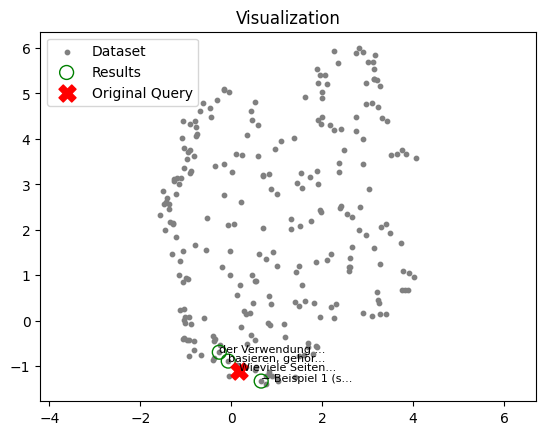

In [20]:

def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Scatter plots
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'Welche hilfsmittel sind erlaubt?'  # Replace with your actual query text if needed
original_query_text = 'Wieviele Seiten muss die Arbeit sein?'  # Replace with your actual query text if needed

plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Visualization')
plt.legend()
plt.show()


---

# 📝 Task: Semantic Retrieval-Augmented Question Answering Using Groq LLM

## Objective
Implement a question-answering system that:
1. Retrieves the most semantically relevant text passages to a user query.
2. Constructs a natural language prompt based on the retrieved content.
3. Uses a large language model (LLM) hosted by Groq to generate an answer.

---

## Task Breakdown

### 1. Embedding-Based Semantic Retrieval
- Use the `SentenceTransformer` model `"Sahajtomar/German-semantic"` to encode a user query into a dense vector embedding.
- Perform a nearest-neighbor search in a prebuilt FAISS index to retrieve the top-**k** similar text chunks. You can **use the prebuilt FAISS form above**.


### 2. LLM Prompt Construction and Query Answering
- Build the prompt:
  - Using the retrieved text chunks, concatenates the results into a context block.
  - Builds a **prompt** asking the LLM to answer the question using that context.
  - Sends the prompt to the **Groq LLM API** (`llama-3.3-70b-versatile`) and returns the response.

### 3. User Query Execution
- An example query (`"What is the most important factor in diagnosing asthma?"`) is used to demonstrate the pipeline.
- The final answer from the LLM is printed.


## Tools & Models Used
- **SentenceTransformers** (`Sahajtomar/German-semantic`) for embedding generation.
- **FAISS** for efficient vector similarity search.
- **Groq LLM API** (`llama-3.3-70b-versatile`) for generating the final response.


In [56]:
import pickle
import faiss
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv
from groq import Groq


In [57]:
groq_api_key = "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"  # Replace with your real key

In [58]:
model = SentenceTransformer("Sahajtomar/German-semantic")

index = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts = pickle.load(f)

In [59]:
def retrieve_texts(query, k, index, token_split_texts, model):
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)

    # Filter out-of-bounds indices
    valid_indices = [i for i in indices[0] if i < len(token_split_texts)]
    retrieved_texts = [token_split_texts[i] for i in valid_indices]

    return retrieved_texts, distances


In [60]:
def answer_query(query, k, index, texts, groq_api_key):
    retrieved_texts, _ = retrieve_texts(query, k, index, texts, model)
    context = "\n\n".join(retrieved_texts)

    prompt = (
        "Answer the following question using the provided context. "
        "Explain it as if you are explaining it to a 5 year old.\n\n"
        f"Context:\n{context}\n\n"
        f"Question: {query}\nAnswer:"
    )

    client = Groq(api_key=groq_api_key)
    messages = [{"role": "system", "content": prompt}]
    llm = client.chat.completions.create(
        messages=messages,
        model="llama-3.3-70b-versatile"
    )

    answer = llm.choices[0].message.content
    return answer


In [61]:
print("Number of text chunks:", len(token_split_texts))

Number of text chunks: 62


In [54]:
query = "What is the most important factor in diagnosing asthma?"
answer = answer_query(query, k=5, index=index, texts=token_split_texts, groq_api_key=groq_api_key)
print("LLM Answer:\n", answer)

LLM Answer:
 Oh boy, let's talk about asthma. So, you know how we can breathe in and out, right? Like when we blow out candles on a birthday cake. Well, sometimes people have trouble breathing and that's because they have something called asthma.

The most important factor in figuring out if someone has asthma is... (are you ready?) ...how they feel and what happens when they breathe. It's like when you run around and play, and then you feel like you can't catch your breath. If that happens a lot, it might mean you have asthma.

Doctors also like to ask questions like: Do you cough a lot at night? Do you get tired easily when you play? Do you ever feel like you can't breathe when you're running around? They also might do some special tests to see how well you can breathe. But mostly, they want to know how you feel and what happens when you breathe. That helps them figure out if you have asthma or not. Isn't that cool?


In [55]:
query = "welche Schwerpunktthemen hat es in der Abteilung Banking & Finance?"
answer = answer_query(query, k=5, index=index, texts=token_split_texts, groq_api_key=groq_api_key)
print("LLM Answer:\n", answer)

LLM Answer:
 Das ist eine gute Frage. Stell dir vor, es gibt eine große Abteilung, die sich mit Geld und Banken beschäftigt. Sie heißt "Banking & Finance". 

In dieser Abteilung gibt es einige wichtige Themen, auf die sie sich konzentrieren. Das sind wie Bausteine, die sie verwenden, um sicherzustellen, dass das Geld und die Banken gut funktionieren.

Einige dieser Schwerpunktthemen sind:

1. **Geld anlegen**: Sie helfen den Leuten, ihr Geld sicher anzulegen, damit es nicht verloren geht.
2. **Kredite**: Sie helfen den Leuten, Geld zu leihen, wenn sie etwas kaufen möchten, aber nicht genug Geld haben.
3. **Banken**: Sie arbeiten mit den Banken zusammen, um sicherzustellen, dass sie gut funktionieren und das Geld der Leute sicher ist.
4. **Vorschriften**: Sie müssen sicherstellen, dass alle Regeln und Vorschriften eingehalten werden, damit alles fair und sicher ist.

Das sind einige der wichtigen Themen in der Abteilung "Banking & Finance". Es ist wie ein großes Puzzle, bei dem alle Tei

## Result Summary

- Embedded query with "Sahajtomar/German-semantic"
- Retrieved top-5 relevant text chunks using FAISS
- Constructed prompt and queried Groq LLM
- Received and printed natural-language response
